<a href="https://colab.research.google.com/github/RamReddymanda/Trading_behaviour_analysis/blob/main/ML_Model_for_trade_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
historical_df = pd.read_csv('/content/drive/MyDrive/Classroom/historical_data.csv')
sentiment_df = pd.read_csv('/content/drive/MyDrive/Classroom/fear_greed_index.csv')
historical_df['Trade Date'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M' , errors='coerce').dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
merged_df = pd.merge(historical_df, sentiment_df, left_on='Trade Date', right_on='date', how='left')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Filter relevant columns
df_ml = merged_df[[
    'classification', 'Side', 'Coin', 'Size USD', 'Fee', 'Direction', 'Closed PnL'
]].dropna()

# Step 2: Define binary target: 1 = Profit, 0 = Not profitable or loss
df_ml['Profitable'] = (df_ml['Closed PnL'] > 0).astype(int)

# Step 3: Encode categorical variables
le_class = LabelEncoder()
le_side = LabelEncoder()
le_coin = LabelEncoder()
le_dir = LabelEncoder()

df_ml['classification'] = le_class.fit_transform(df_ml['classification'])
df_ml['Side'] = le_side.fit_transform(df_ml['Side'])
df_ml['Coin'] = le_coin.fit_transform(df_ml['Coin'])
df_ml['Direction'] = le_dir.fit_transform(df_ml['Direction'])

# Step 4: Define X and y
X = df_ml.drop(['Closed PnL', 'Profitable'], axis=1)
y = df_ml['Profitable']


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9376716220054919

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95     24848
           1       0.91      0.94      0.93     17396

    accuracy                           0.94     42244
   macro avg       0.93      0.94      0.94     42244
weighted avg       0.94      0.94      0.94     42244



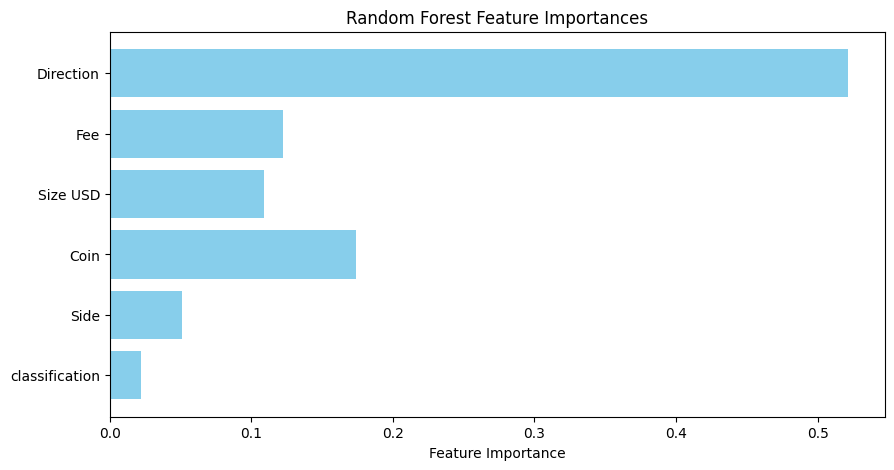

In [4]:
import matplotlib.pyplot as plt

# Feature importance plot
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 5))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()


In [8]:
import numpy as np

# Sample trades: match the order of features used during training
sample_data = pd.DataFrame({
    'classification': le_class.transform(['Fear', 'Extreme Greed', 'Neutral']),
    'Side': le_side.transform(['BUY', 'SELL', 'BUY']),
    'Coin': le_coin.transform(['BTC', 'ETH', 'SOL']),
    'Size USD': [1000, 2500, 500],
    'Fee': [0.1, 0.05, 0.02],
    'Direction': le_dir.transform(['Open Long', 'Close Long', 'Buy']),
})

# Show sample
sample_data


,classification,Side,Coin,Size USD,Fee,Direction
0,2,0,105,1000,0.10,6
1,1,1,120,2500,0.05,2
2,4,0,205,500,0.02,1


In [9]:
# Predict whether the sample trades will be profitable
sample_preds = model.predict(sample_data)
sample_probs = model.predict_proba(sample_data)

# Show results
for i, pred in enumerate(sample_preds):
    label = 'Profitable' if pred == 1 else 'Not Profitable'
    prob = sample_probs[i][pred] * 100
    print(f"Trade {i+1}: {label} (Confidence: {prob:.2f}%)")


Trade 1: Not Profitable (Confidence: 100.00%)
Trade 2: Profitable (Confidence: 65.00%)
Trade 3: Not Profitable (Confidence: 89.00%)


In [7]:
print(le_dir.classes_)


['Auto-Deleveraging' 'Buy' 'Close Long' 'Close Short'
 'Liquidated Isolated Short' 'Long > Short' 'Open Long' 'Open Short'
 'Sell' 'Settlement' 'Short > Long' 'Spot Dust Conversion']
